In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [2]:
# Let's load the IDA2016 Challenge dataset
import pandas as pd
import numpy as np

df = pd.read_csv('IDA2016Challenge/aps_failure_training_set.csv')
df.head()


,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


In [3]:
# let's replace all the 'na' with 0.
df[df == 'na'] = 0
df_us = df

In [ ]:
# let's try some random undersampling.
df_pos = df[df['class']=='pos']
df_neg = df[df['class']=='neg']
df_neg_us = df_neg.sample(10000)
df_us = pd.concat((df_pos,df_neg_us))
df_us.shape

In [4]:
# extract the features and labels
y = df_us['class']
X = df_us.drop(columns=['class'])
print("X dims =", X.shape)
print("Y distrib =", y.value_counts())

X dims = (60000, 170)
Y distrib = class
neg    59000
pos     1000
Name: count, dtype: int64


In [5]:
# y.values gets us (N,1) and ravel() gets us (N,) as the shapes.
ybin = y.values.ravel()
print(ybin)

['neg' 'neg' 'neg' ... 'neg' 'neg' 'neg']


In [6]:
# let's partition the data into train-test splits
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, ybin,
                                                random_state=42)

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(Xtrain.astype(np.float32))
X_test_scaled = scaler.transform(Xtest)

### Let's build the SVM classifier to get the baseline

In [34]:
model_rbf = SVC(kernel='rbf')

param_grid = {'C': [50, 100, 500, 1000],
              'gamma': [1E-5, 0.0001, 0.001]}
              #'class_weight': ['balanced', None]}
# use -1 to use all the CPUs to perform the grid search.
grid_rbf = GridSearchCV(model_rbf, param_grid, n_jobs=-1, verbose=20)

sample_weight = [500 if yt == 'pos' else 10 for yt in ytrain]
%time grid_rbf.fit(X_train_scaled, ytrain, sample_weight=sample_weight)
print(grid_rbf.best_params_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 3/5; 1/12] START C=50, gamma=1e-05..........................................
[CV 1/5; 1/12] START C=50, gamma=1e-05..........................................
[CV 4/5; 1/12] START C=50, gamma=1e-05..........................................
[CV 1/5; 2/12] START C=50, gamma=0.0001.........................................
[CV 5/5; 1/12] START C=50, gamma=1e-05..........................................
[CV 4/5; 2/12] START C=50, gamma=0.0001.........................................
[CV 5/5; 2/12] START C=50, gamma=0.0001.........................................
[CV 3/5; 3/12] START C=50, gamma=0.001..........................................
[CV 2/5; 1/12] START C=50, gamma=1e-05..........................................
[CV 3/5; 2/12] START C=50, gamma=0.0001.........................................
[CV 4/5; 3/12] START C=50, gamma=0.001..........................................
[CV 1/5; 3/12] START C=50, gamma=0.001..........

In [33]:
model_lin = SVC(kernel='linear')

param_grid_lin = {'C': [50, 100, 500, 1000]}
# use -1 to use all the CPUs to perform the grid search.
grid_lin = GridSearchCV(model_lin, param_grid_lin, n_jobs=-1, verbose=20)

sample_weight = [500 if yt == 'pos' else 10 for yt in ytrain]
%time grid_lin.fit(X_train_scaled, ytrain, sample_weight=sample_weight)
print(grid_lin.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START C=50........................................................
[CV 4/5; 1/4] START C=50........................................................
[CV 3/5; 1/4] START C=50........................................................
[CV 2/5; 1/4] START C=50........................................................
[CV 1/5; 2/4] START C=100.......................................................
[CV 2/5; 2/4] START C=100.......................................................
[CV 4/5; 2/4] START C=100.......................................................
[CV 5/5; 2/4] START C=100.......................................................
[CV 2/5; 3/4] START C=500.......................................................
[CV 1/5; 3/4] START C=500.......................................................
[CV 5/5; 1/4] START C=50........................................................
[CV 3/5; 3/4] START C=500........................

KeyboardInterrupt: 

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [35]:
best_model = grid_rbf.best_estimator_

model_svc = SVC(kernel='rbf', C=50, gamma=0.001).fit(X_train_scaled, ytrain, sample_weight=sample_weight)

yfit = model_svc.predict(X_test_scaled)



In [37]:
print("Neg Data points:", np.sum(ytrain=='neg'))
print("Neg Support Points:", np.sum(ytrain[best_model.support_]=='neg'))
print("Pos Data points:", np.sum(ytrain=='pos'))
print("Pos Support Points:", np.sum(ytrain[best_model.support_]=='pos'))


Neg Data points: 44254
Neg Support Points: 1019
Pos Data points: 746
Pos Support Points: 435


In [38]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit, zero_division=0))

              precision    recall  f1-score   support

         neg       0.99      1.00      0.99     14746
         pos       0.71      0.60      0.65       254

    accuracy                           0.99     15000
   macro avg       0.85      0.80      0.82     15000
weighted avg       0.99      0.99      0.99     15000



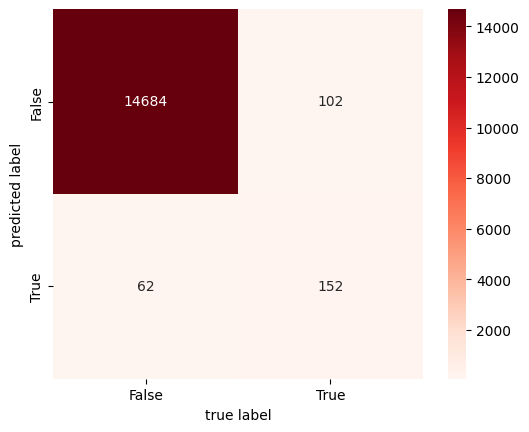

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
mat = confusion_matrix(ytest, yfit)
labels = ["False", 'True']

sns.heatmap(mat.T, square=True, annot=True, fmt='d',
            cbar=True, cmap='Reds',
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [84]:
logreg = LogisticRegression(max_iter=10000, class_weight={'pos':10, 'neg':500}).fit(X_train_scaled, ytrain)
yhat_logreg = logreg.predict(X_test_scaled)
print(classification_report(ytest, yhat_logreg, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(ytest, yhat_logreg))

logreg = LogisticRegression(max_iter=10000, class_weight={'pos':10, 'neg':500}).fit(Xtrain, ytrain)
yhat_logreg = logreg.predict(Xtest)
print(classification_report(ytest, yhat_logreg, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(ytest, yhat_logreg))

              precision    recall  f1-score   support

         neg       0.99      1.00      0.99     14746
         pos       0.92      0.37      0.53       254

    accuracy                           0.99     15000
   macro avg       0.96      0.69      0.76     15000
weighted avg       0.99      0.99      0.99     15000

Confusion Matrix:
 [[14738     8]
 [  159    95]]


/store/venv/da5401/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

         neg       0.99      1.00      0.99     14746
         pos       0.88      0.36      0.51       254

    accuracy                           0.99     15000
   macro avg       0.93      0.68      0.75     15000
weighted avg       0.99      0.99      0.99     15000

Confusion Matrix:
 [[14733    13]
 [  163    91]]


In [68]:
# get the positive points
ytrain_pos = ytrain[ytrain=='pos']
xtrain_pos = X_train_scaled[ytrain=='pos']
print("Pos Training data:", xtrain_pos.shape)

# get the negative from the dataset.
ytrain_neg = ytrain[ytrain=='neg']

# under sample the negative points
ids = np.arange(0, ytrain_neg.shape[0])
sample_ids = np.random.choice(ids, 5000, replace=False)

ytrain_neg = ytrain_neg[sample_ids]
xtrain_neg = X_train_scaled[sample_ids]
print("Neg Undersampled Training data:", xtrain_neg.shape)

print("Positive Support points:", np.sum(ytrain[best_model.support_]=='pos'))
print("Negative Support points:", np.sum(ytrain[best_model.support_]=='neg'))

# add the positives, undersampled negatives, and support points
X_stacked = np.concatenate((X_train_scaled[best_model.support_], xtrain_pos, xtrain_neg), axis=0)
y_stacked = np.concatenate((ytrain[best_model.support_], ytrain_pos, ytrain_neg), axis=0)
print("Stacked Training data:", X_stacked.shape)

print("Resampled Train Data: pos = ", np.sum(y_stacked=='pos'))
print("Resampled Train Data: neg = ", np.sum(y_stacked=='neg'))

logreg_s = LogisticRegression(max_iter=10000, class_weight={'pos':10, 'neg':20}).fit(X_stacked, y_stacked)
yhat_logreg = logreg_s.predict(X_test_scaled)
print("\nTesting Classification Performance:\n", classification_report(ytest, yhat_logreg, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(ytest, yhat_logreg))

Pos Training data: (746, 170)
Neg Undersampled Training data: (5000, 170)
Positive Support points: 435
Negative Support points: 1019
Stacked Training data: (7200, 170)
Resampled Train Data: pos =  1181
Resampled Train Data: neg =  6019

Testing Classification Performance:
               precision    recall  f1-score   support

         neg       0.99      0.99      0.99     14746
         pos       0.61      0.63      0.62       254

    accuracy                           0.99     15000
   macro avg       0.80      0.81      0.81     15000
weighted avg       0.99      0.99      0.99     15000

Confusion Matrix:
 [[14645   101]
 [   95   159]]


In [83]:
from sklearn.tree import DecisionTreeClassifier
model_tree = DecisionTreeClassifier(max_depth=2, class_weight={'pos':5, 'neg':3}, random_state=42).fit(X_train_scaled, ytrain)
yhat_tree = model_tree.predict(X_test_scaled)
print(classification_report(ytest, yhat_tree, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(ytest, yhat_tree))

model_tree = DecisionTreeClassifier(max_depth=2, class_weight={'pos':5, 'neg':3}, random_state=42).fit(Xtrain, ytrain)
yhat_tree = model_tree.predict(Xtest)
print(classification_report(ytest, yhat_tree, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(ytest, yhat_tree))

              precision    recall  f1-score   support

         neg       0.99      1.00      0.99     14746
         pos       0.68      0.31      0.42       254

    accuracy                           0.99     15000
   macro avg       0.83      0.65      0.71     15000
weighted avg       0.98      0.99      0.98     15000

Confusion Matrix:
 [[14709    37]
 [  176    78]]
              precision    recall  f1-score   support

         neg       0.99      1.00      0.99     14746
         pos       0.68      0.31      0.42       254

    accuracy                           0.99     15000
   macro avg       0.83      0.65      0.71     15000
weighted avg       0.98      0.99      0.98     15000

Confusion Matrix:
 [[14709    37]
 [  176    78]]
